In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_13_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_14.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_14_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_15.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299

In [3]:
# Import libraries
import os
import cv2
import IPython
import random
import glob
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Model , load_model
from keras.applications import VGG19
from keras.applications import DenseNet121
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [4]:
# Image config
img_size = 256
num_channels = 3

In [5]:
# This dataset contains 110 brain MR images together with manual FLAIR abnormality segmentation masks. All images are with 3 channels per image. Masks are binary, 1-channel images.
# https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
root_folder = './lgg-mri-segmentation/kaggle_3m/'

In [6]:
# loading dataset
masks = glob.glob(f"{root_folder}*/*_mask*")
diagnosis = [np.any(cv2.imread(file)) for file in masks]
images = [file.replace('_mask', '') for file in masks]
print("Images: ", len(images))
print("Masks: ",len(masks))

Images:  3929
Masks:  3929


In [7]:
# Sorting check
idx = random.randint(0, len(images)-1)
print("Path to the Image:", images[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_28.tif 
Path to the Mask: ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_28_mask.tif


In [8]:
missing_masks = 0
for folder in os.listdir(root_folder):
    folderpath = os.path.join(root_folder, folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        if file[:len(file)-4][-1].isnumeric():
            if file[:len(file)-4]+'_mask.tif' not in filelist:
                missing_masks += 1
                print(f"Image without mask: {os.path.join(folderpath, file)}")
print(f"Total number of missing masks: {missing_masks}")

Total number of missing masks: 0


In [9]:
df = pd.DataFrame({"image_path": images, "mask_path": masks, "diagnosis": diagnosis})
df

image_path  \
0     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_...   
1     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_...   
2     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_...   
3     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_...   
4     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_...   
...                                                 ...   
3924  ./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6290_...   
3925  ./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6290_...   
3926  ./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6290_...   
3927  ./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6290_...   
3928  ./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6290_...   

                                              mask_path  diagnosis  
0     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_...      False  
1     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_...      False  
2     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_...      False  
3     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_...       True  
4     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_...      False  
...                                                 ...        ...  
3924  ./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6290_...       True  
3925  ./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6290_...      False  
3926  ./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6290_...      False  
3927  ./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6290_...      False  
3928  ./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6290_...      False  

[3929 rows x 3 columns]

False    2556
True     1373
Name: diagnosis, dtype: int64


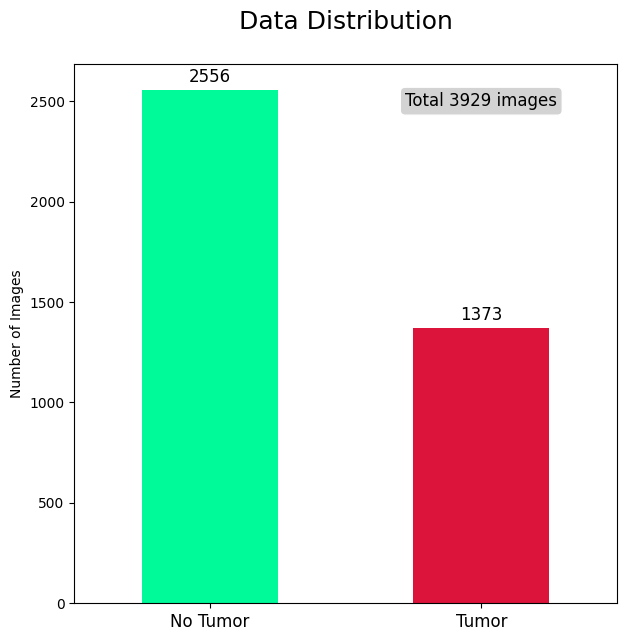

In [10]:
# Plot
print(df['diagnosis'].value_counts())
ax = df['diagnosis'].value_counts().plot(kind='bar',stacked=True,figsize=(7, 7),color=["mediumspringgreen", "crimson"])
ax.set_xticklabels(["No Tumor", "Tumor"], rotation=0, fontsize=12);
ax.set_ylabel('Number of Images', fontsize = 10)
ax.set_title("Data Distribution",fontsize = 18, y=1.05)

for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+20), rotation=0, color="black", ha="center", verticalalignment='bottom', fontsize=12)

ax.text(1, 2500, f"Total {len(df)} images", size=12, color="black", ha="center", va="center", bbox=dict(boxstyle="round", fc=("lightgray"), ec=("white")));

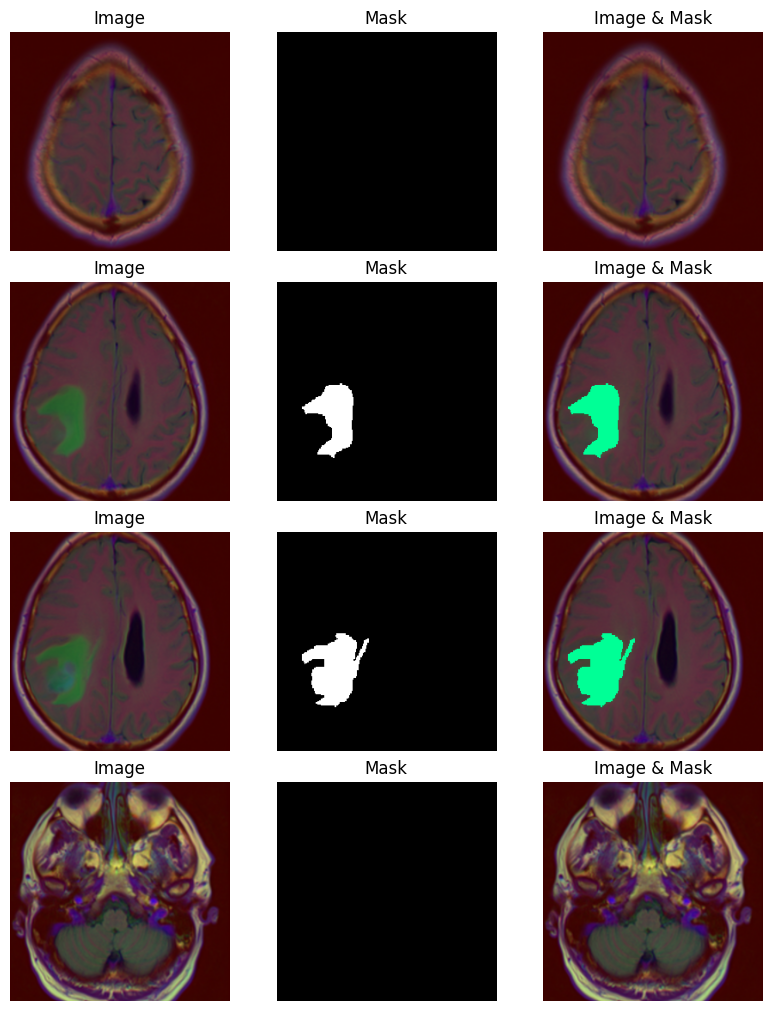

In [11]:
# visualizing data
count = 0
i = 0
fig, axs = plt.subplots(4, 3, figsize=(8, 10), constrained_layout=True)
for sample in df['diagnosis']:
    # read images
    img = io.imread(df.image_path[i+5])
    axs[count][0].imshow(img, cmap='bone')
    axs[count][0].set_title('Image', fontdict = {'fontsize':12})
    axs[count][0].axis(False)

    # read masks
    msk = io.imread(df.mask_path[i+5])
    axs[count][1].imshow(msk, cmap='gray')
    axs[count][1].set_title('Mask' , fontdict = {'fontsize':12})
    axs[count][1].axis(False)

    img[msk==255] = (0,255,150)
    axs[count][2].imshow(img)
    axs[count][2].set_title("Image & Mask", fontdict = {'fontsize':12})
    axs[count][2].axis(False)

    count +=1
    i += 1
    if (count==4):
        break

plt.show()

In [12]:
# Convert the data in diagnosis column to string format, to use categorical mode in flow_from_dataframe
df['diagnosis'] = df['diagnosis'].apply(lambda x: str(x))
# spliting data
train_df, test_df = train_test_split(df, stratify=df['diagnosis'], test_size=0.10, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(f"Train : {train_df.shape}")
print(f"Test : {test_df.shape}")

Train : (3536, 3)
Test : (393, 3)


In [13]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(img_size,img_size),
        seed=1):

    image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**aug_dict)
    mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.0
    mask = mask / 255.0
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

In [14]:
train_gen = train_generator(train_df, 16, dict(), target_size=(img_size, img_size))
test_gen = train_generator(test_df, 16, dict(), target_size=(img_size, img_size))

In [15]:
x,y = next(train_gen)
print(x.shape)
print(y.shape)

Found 3536 validated image filenames.
Found 3536 validated image filenames.
(16, 256, 256, 3)
(16, 256, 256, 1)


# Classic U-Net Model

In [ ]:
# U-net model
def encoding_block(inputs, filters, max_pooling=True):

    C = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(inputs)
    C = layers.BatchNormalization()(C)
    C = layers.Activation("relu")(C)

    C = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = layers.BatchNormalization()(C)
    C = layers.Activation("relu")(C)

    skip_connection = C

    if max_pooling:
        next_layer = layers.MaxPooling2D(pool_size=(2, 2))(C)
    else:
        next_layer = C

    return next_layer, skip_connection

In [ ]:
def decoding_block(inputs, skip_connection_input, filters):
    CT = layers.Conv2DTranspose(filters, 3, strides=(2,2), padding="same", kernel_initializer="he_normal")(inputs)

    residual_connection = layers.concatenate([CT, skip_connection_input], axis=3)

    C = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(residual_connection)
    C = layers.BatchNormalization()(C)
    C = layers.Activation("relu")(C)

    C = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = layers.BatchNormalization()(C)
    C = layers.Activation("relu")(C)

    return C

In [ ]:
def unet_model(input_size, filters):
    inputs = layers.Input(input_size)

    # Encoder
    C1, S1 = encoding_block(inputs, filters, max_pooling=True)
    C2, S2 = encoding_block(C1, filters * 2, max_pooling=True)
    C3, S3 = encoding_block(C2, filters * 4, max_pooling=True)
    C4, S4 = encoding_block(C3, filters * 8, max_pooling=True)

    C5, S5 = encoding_block(C4, filters * 16, max_pooling=False)

    # Decoder
    U6 = decoding_block(C5, S4, filters * 8)
    U7 = decoding_block(U6, S3,  filters * 4)
    U8 = decoding_block(U7, S2,  filters = filters * 2)
    U9 = decoding_block(U8, S1,  filters = filters)

    C10 = layers.Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(U9)

    C11 = layers.Conv2D(1, kernel_size = (1,1), activation='sigmoid', padding='same')(C10)

    model = Model(inputs=inputs, outputs=C11)

    return model

In [ ]:
unet_model = unet_model((img_size, img_size, num_channels), filters=32)
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 32)         0         ['batch_normalization[0][0

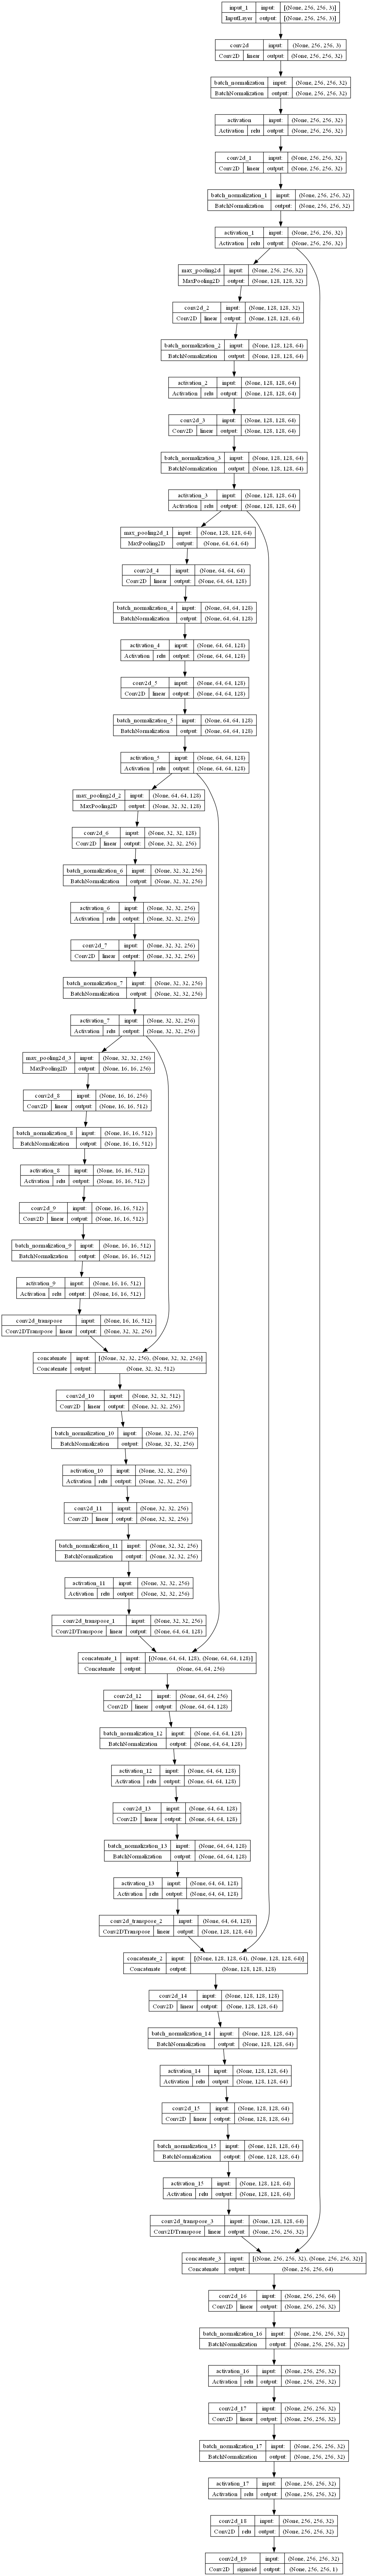

In [ ]:
keras.utils.plot_model(
    unet_model,
    to_file='./img/UNet_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [ ]:
# compile the model
unet_model.compile(optimizer=Adam(lr = 0.0001), loss='binary_crossentropy', metrics=["accuracy"])

checkpoint_unet = ModelCheckpoint("./CNN_UNet.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='max')
early_stopping_unet = EarlyStopping(monitor='val_loss', patience=20,verbose=1, restore_best_weights=True)
reduce_learningrate_unet = ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=10, verbose=1, min_lr = 2e-6)

callbacks_list_unet = [early_stopping_unet,checkpoint_unet,reduce_learningrate_unet]

In [ ]:
history_unet = unet_model.fit(train_gen, batch_size = 16, steps_per_epoch=len(train_df) / 16, verbose=1, epochs= 30, validation_data=test_gen, validation_steps=len(test_df) / 16, callbacks = callbacks_list_unet)

Epoch 1/30
221/221 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9927Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_loss improved from -inf to 0.02782, saving model to ./CNN_UNet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


221/221 [==============================] - 98s 444ms/step - loss: 0.0196 - accuracy: 0.9927 - val_loss: 0.0278 - val_accuracy: 0.9926 - lr: 0.0010
Epoch 2/30
221/221 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9944
Epoch 2: val_loss did not improve from 0.02782
221/221 [==============================] - 92s 415ms/step - loss: 0.0178 - accuracy: 0.9944 - val_loss: 0.0189 - val_accuracy: 0.9943 - lr: 0.0010
Epoch 3/30
221/221 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9949
Epoch 3: val_loss did not improve from 0.02782
221/221 [==============================] - 90s 405ms/step - loss: 0.0169 - accuracy: 0.9949 - val_loss: 0.0222 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 4/30
221/221 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9951
Epoch 4: val_loss did not improve from 0.02782
221/221 [==============================] - 92s 415ms/step - loss: 0.0158 - accuracy: 0.9951 - val_loss: 0.0152 - val_accuracy: 0.9

In [ ]:
df_result_unet = pd.DataFrame(history_unet.history)
df_result_unet

loss  accuracy  val_loss  val_accuracy     lr
0   0.019563  0.992685  0.027820      0.992642  0.001
1   0.017844  0.994435  0.018890      0.994254  0.001
2   0.016875  0.994890  0.022199      0.993630  0.001
3   0.015762  0.995109  0.015220      0.995589  0.001
4   0.014523  0.995313  0.020136      0.995122  0.001
5   0.012131  0.995869  0.012402      0.995371  0.001
6   0.010713  0.996155  0.012948      0.995514  0.001
7   0.010188  0.996306  0.013010      0.995520  0.001
8   0.009541  0.996558  0.033154      0.986840  0.001
9   0.009020  0.996707  0.008811      0.996726  0.001
10  0.008424  0.996843  0.010544      0.996600  0.001
11  0.008489  0.996910  0.008307      0.996881  0.001
12  0.007215  0.997273  0.008489      0.996686  0.001
13  0.007197  0.997269  0.008932      0.996598  0.001
14  0.006502  0.997534  0.008676      0.996807  0.001
15  0.006333  0.997596  0.012854      0.996555  0.001
16  0.006294  0.997586  0.017232      0.993597  0.001
17  0.005741  0.997794  0.005765      0.997826  0.001
18  0.005351  0.997905  0.007619      0.997613  0.001
19  0.005190  0.997990  0.008550      0.997142  0.001
20  0.005738  0.997780  0.006027      0.997823  0.001
21  0.004816  0.998113  0.006213      0.997656  0.001
22  0.004973  0.998055  0.007375      0.997222  0.001
23  0.006007  0.997688  0.007931      0.996999  0.001
24  0.005288  0.997946  0.006728      0.997402  0.001
25  0.004408  0.998246  0.004848      0.998155  0.001
26  0.004230  0.998303  0.005872      0.997821  0.001
27  0.004142  0.998336  0.006207      0.997735  0.001
28  0.004038  0.998371  0.005660      0.997922  0.001
29  0.003934  0.998408  0.005474      0.998011  0.001

In [ ]:
# evalute model
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

loss_unet,acc_unet = unet_model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("accuracy:", acc_unet)

131/131 [==============================] - 16s 119ms/step - loss: 0.0059 - accuracy: 0.9980
accuracy: 0.9979679584503174


<Axes: >

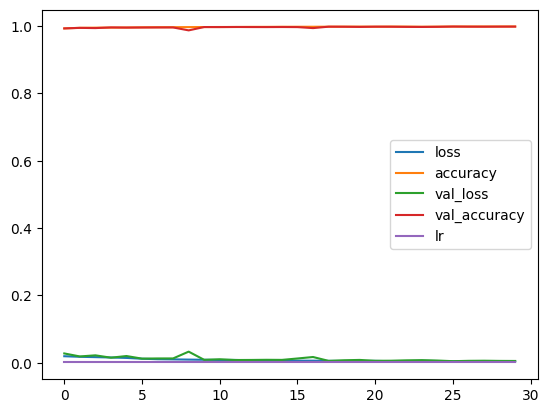

In [ ]:
pd.DataFrame(history_unet.history).plot()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax = ax.ravel()
metrics_unet = ['Accuracy', 'Loss']

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_unet.history[met], 'o-',color= 'navy')
    ax[i].plot(history_unet.history['val_' + met], 'o-',color= 'orangered')
    ax[i].set_title('{} & Number of Epochs'.format(metrics_unet[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics_unet[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")

In [ ]:
y_pred_unet=unet_model.predict(test_gen, steps= test_steps)

131/131 [==============================] - 15s 109ms/step


In [ ]:
unet_model.save("./CNN_Unet.h5")

In [ ]:
unet_model = load_model('./models/CNN_Unet.h5', compile=True, safe_mode=True)

In [ ]:
# evalute model
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

loss_unet,acc_unet= unet_model.evaluate(test_gen, steps= test_steps, verbose=1)
print("accuracy:", acc_unet)

Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 [==============================] - 293s 2s/step - loss: 0.0042 - accuracy: 0.9984
accuracy: 0.9983938336372375


1/1 [==============================] - 0s 155ms/step


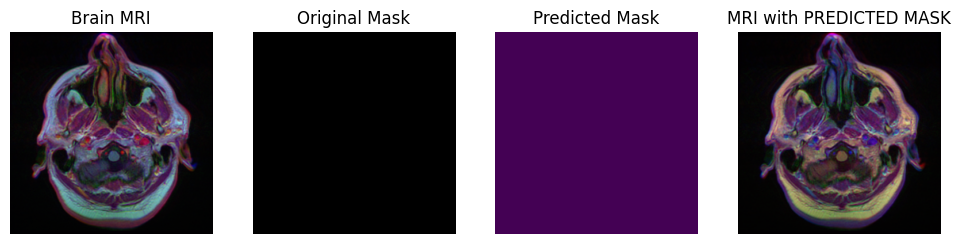

1/1 [==============================] - 0s 134ms/step


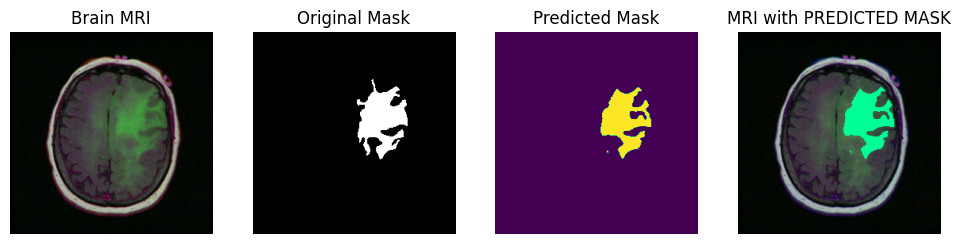

1/1 [==============================] - 0s 133ms/step


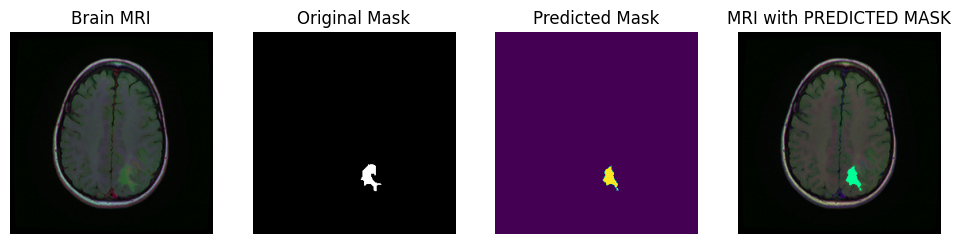

1/1 [==============================] - 0s 169ms/step


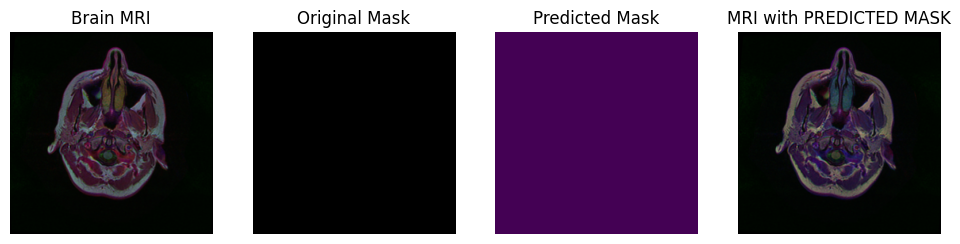

1/1 [==============================] - 0s 138ms/step


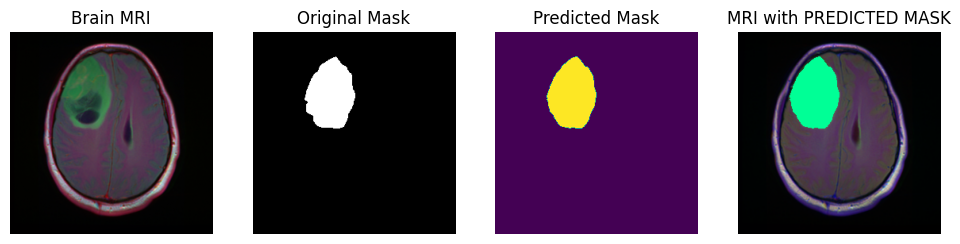

1/1 [==============================] - 0s 173ms/step


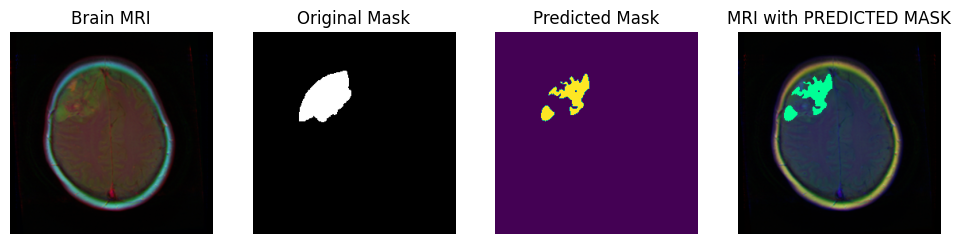

In [ ]:
#visualizing prediction
for _ in range(6):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['image_path'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = unet_model.predict(img)

    plt.figure(figsize=(12, 12))

    plt.subplot(1, 4, 1)
    plt.imshow(np.array(img).squeeze())
    plt.axis('off')
    plt.title('Brain MRI')

    plt.subplot(1, 4, 2)
    mask = cv2.imread(test_df['mask_path'].iloc[index])
    plt.imshow(np.array(mask).squeeze())
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 4, 3)
    pred = np.array(predicted_img).squeeze().round()
    plt.imshow(pred)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    img_ = cv2.imread(test_df['image_path'].iloc[index])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[pred==1] = (0,255,150)
    plt.imshow(img_)
    plt.title('MRI with PREDICTED MASK')
    plt.axis('off')

    plt.show()

### Attention UNet

In [25]:
# Attention U-net Model
def conv_block_Attention_unet(x, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def encoder_block_Attention_unet(x, num_filters):
    x = conv_block_Attention_unet(x, num_filters)
    p = layers.MaxPool2D((2, 2))(x)
    return x, p

In [26]:

def attention_gate(g, s, num_filters):
    Wg = layers.Conv2D(num_filters, 1, padding="same")(g)
    Wg = layers.BatchNormalization()(Wg)

    Ws = layers.Conv2D(num_filters, 1, padding="same")(s)
    Ws = layers.BatchNormalization()(Ws)

    out = layers.Activation("relu")(Wg + Ws)
    out = layers.Conv2D(num_filters, 1, padding="same")(out)
    out = layers.Activation("sigmoid")(out)

    return out * s

In [27]:
def decoder_block_Attention_unet(x, s, num_filters):
    x = layers.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = layers.Concatenate()([x, s])
    x = conv_block_Attention_unet(x, num_filters)
    return x

In [28]:
def attention_unet(input_size):
    inputs = layers.Input(input_size)

    s1, p1 = encoder_block_Attention_unet(inputs, 64)
    s2, p2 = encoder_block_Attention_unet(p1, 128)
    s3, p3 = encoder_block_Attention_unet(p2, 256)

    b1 = conv_block_Attention_unet(p3, 512)

    d1 = decoder_block_Attention_unet(b1, s3, 256)
    d2 = decoder_block_Attention_unet(d1, s2, 128)
    d3 = decoder_block_Attention_unet(d2, s1, 64)

    outputs = layers.Conv2D(1, kernel_size = (1,1), padding="same", activation="softmax")(d3)
    Attention_unet_model = Model(inputs, outputs, name="Attention-UNET")
    return Attention_unet_model

In [29]:
Attention_unet_model = attention_unet((img_size, img_size, num_channels))
Attention_unet_model.summary()

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normaliza

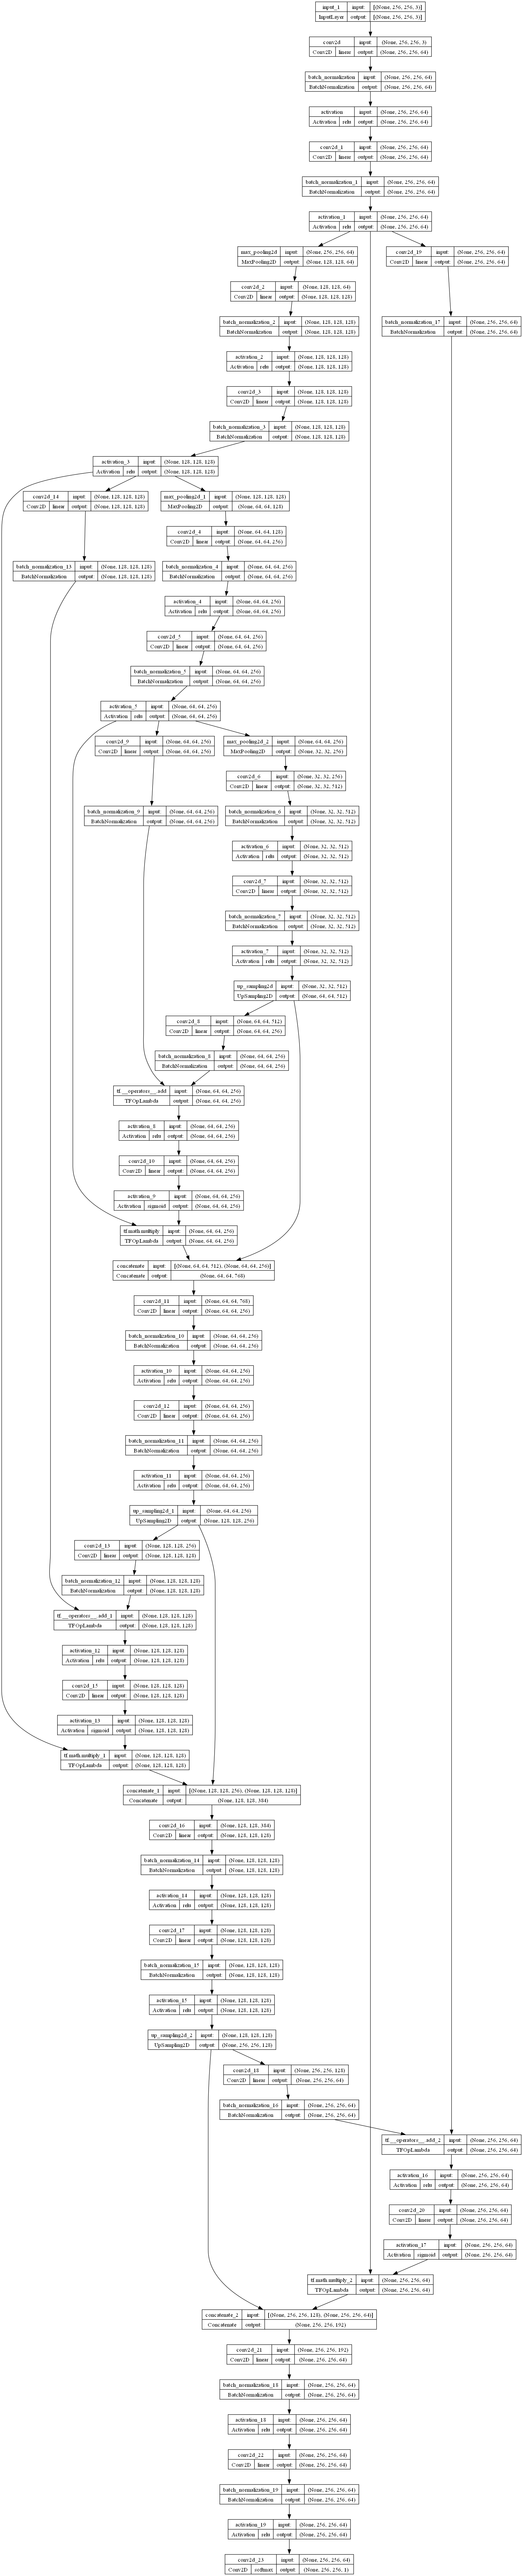

In [ ]:

keras.utils.plot_model(
    Attention_unet_model,
    to_file='./img/Attention_UNet_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [30]:
# compile the model
Attention_unet_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=["accuracy"])

checkpoint_Attention_unet = ModelCheckpoint("./Attention_UNet.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='max')
early_stopping_Attention_unet = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_learningrate_Attention_unet = ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=10, verbose=1, min_lr = 2e-6)

callbacks_list_Attention_unet = [early_stopping_Attention_unet,checkpoint_Attention_unet,reduce_learningrate_Attention_unet]

In [31]:
history_Attention_unet = Attention_unet_model.fit(train_gen, batch_size = 16, steps_per_epoch=len(train_df) / 16, verbose=1, epochs= 30, validation_data=test_gen, validation_steps=len(test_df) / 16, callbacks = callbacks_list_Attention_unet)

Epoch 1/30
221/221 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.0103Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_loss improved from -inf to 0.05917, saving model to ./Attention_UNet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


221/221 [==============================] - 310s 1s/step - loss: 0.0662 - accuracy: 0.0103 - val_loss: 0.0592 - val_accuracy: 0.0106 - lr: 0.0010
Epoch 2/30
221/221 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.0103
Epoch 2: val_loss improved from 0.05917 to 0.06183, saving model to ./Attention_UNet.h5
221/221 [==============================] - 250s 1s/step - loss: 0.0282 - accuracy: 0.0103 - val_loss: 0.0618 - val_accuracy: 0.0102 - lr: 0.0010
Epoch 3/30
221/221 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.0102
Epoch 3: val_loss did not improve from 0.06183
221/221 [==============================] - 249s 1s/step - loss: 0.0224 - accuracy: 0.0102 - val_loss: 0.0258 - val_accuracy: 0.0114 - lr: 0.0010
Epoch 4/30
221/221 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.0103
Epoch 4: val_loss did not improve from 0.06183
221/221 [==============================] - 248s 1s/step - loss: 0.0198 - accuracy: 0.0103 - val

KeyboardInterrupt: 

In [ ]:
df_Attention_unet = pd.DataFrame(history_Attention_unet.history)
df_Attention_unet

In [ ]:
loss_Attention_unet,acc_Attention_unet = Attention_unet_model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("accuracy:", acc_Attention_unet)

In [ ]:
pd.DataFrame(history_Attention_unet.history).plot()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax = ax.ravel()
metrics_unet = ['Accuracy', 'Loss']

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_unet.history[met], 'o-',color= 'navy')
    ax[i].plot(history_unet.history['val_' + met], 'o-',color= 'orangered')
    ax[i].set_title('{} & Number of Epochs'.format(metrics_unet[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics_unet[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")

In [ ]:
y_pred_Attention_unet=Attention_unet_model.predict(test_gen, steps= test_steps)

In [ ]:
Attention_unet_model.save("Attention_Unet.h5")

In [ ]:
#visualizing prediction
for _ in range(6):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['image_path'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = Attention_unet_model.predict(img)

    plt.figure(figsize=(12, 12))

    plt.subplot(1, 4, 1)
    plt.imshow(np.array(img).squeeze())
    plt.axis('off')
    plt.title('Brain MRI')

    plt.subplot(1, 4, 2)
    mask = cv2.imread(test_df['mask_path'].iloc[index])
    plt.imshow(np.array(mask).squeeze())
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 4, 3)
    pred = np.array(predicted_img).squeeze().round()
    plt.imshow(pred)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    img_ = cv2.imread(test_df['image_path'].iloc[index])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[pred==1] = (0,255,150)
    plt.imshow(img_)
    plt.title('MRI with PREDICTED MASK')
    plt.axis('off')

    plt.show()

### Densenet-121 U-Net Model

In [16]:
# Densenet-121 model

def conv_block_Densenet(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def decoder_block_Densenet(inputs, skip_connection_input, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_connection_input])
    x = conv_block_Densenet(x, num_filters)
    return x

In [19]:
def build_Densenet_unet(input_size):
    inputs = layers.Input(input_size)
    Densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

# encoder
    s1 = Densenet.get_layer("input_2").output         # (256 x 256)
    s2 = Densenet.get_layer("conv1/relu").output      # (128 x 128)
    s3 = Densenet.get_layer("pool2_relu").output      # (64 x 64)
    s4 = Densenet.get_layer("pool3_relu").output      # (32 x 32)

    # bridge
    b1 = Densenet.get_layer("pool4_relu").output      # (16 x 16)

    # decoder
    d1 = decoder_block_Densenet(b1, s4, 256)
    d2 = decoder_block_Densenet(d1, s3, 128)
    d3 = decoder_block_Densenet(d2, s2, 64)
    d4 = decoder_block_Densenet(d3, s1, 32)

    # output
    dropout = layers.Dropout(0.3)(d4)
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(dropout)

    model_Densenet = Model(inputs, outputs, name="Densenet-121-UNet")
    return model_Densenet

In [20]:
model_Densenet = build_Densenet_unet((img_size, img_size, num_channels))
model_Densenet.summary()

Model: "Densenet-121-UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 262, 262, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0

In [22]:
keras.utils.plot_model(
    model_Densenet,
    to_file='./DenseUNet_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

Output hidden; open in https://colab.research.google.com to view.

In [23]:
# compile the model
model_Densenet.compile(optimizer=Adam(lr = 0.0001), loss='binary_crossentropy', metrics=["accuracy"])

checkpoint_Densenet = ModelCheckpoint("./Densenet_UNet.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='max')
early_stopping_Densenet = EarlyStopping(monitor='val_loss', patience=20,verbose=1, restore_best_weights=True)
reduce_learningrate_Densenet = ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=10, verbose=1, min_lr = 2e-6)

callbacks_list_Densenet = [early_stopping_Densenet,checkpoint_Densenet,reduce_learningrate_Densenet]

In [24]:
history_Densenet = model_Densenet.fit(train_gen, batch_size = 16, steps_per_epoch=len(train_df) / 16, verbose=1, epochs= 30, validation_data=test_gen, validation_steps=len(test_df) / 16, callbacks = callbacks_list_Densenet)

Epoch 1/30
221/221 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9912Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_loss improved from -inf to 0.13800, saving model to ./Densenet_UNet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


221/221 [==============================] - 224s 661ms/step - loss: 0.0844 - accuracy: 0.9912 - val_loss: 0.1380 - val_accuracy: 0.9566 - lr: 0.0010
Epoch 2/30
221/221 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9956
Epoch 2: val_loss did not improve from 0.13800
221/221 [==============================] - 129s 583ms/step - loss: 0.0224 - accuracy: 0.9956 - val_loss: 0.0197 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 3/30
221/221 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9964
Epoch 3: val_loss did not improve from 0.13800
221/221 [==============================] - 129s 583ms/step - loss: 0.0142 - accuracy: 0.9964 - val_loss: 0.0147 - val_accuracy: 0.9959 - lr: 0.0010
Epoch 4/30
221/221 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9968
Epoch 4: val_loss did not improve from 0.13800
221/221 [==============================] - 127s 573ms/step - loss: 0.0112 - accuracy: 0.9968 - val_loss: 0.0111 - val_accuracy:

In [25]:
df_result_Densenet = pd.DataFrame(history_Densenet.history)
df_result_Densenet

loss  accuracy  val_loss  val_accuracy      lr
0   0.084420  0.991174  0.137999      0.956566  0.0010
1   0.022369  0.995593  0.019718      0.993313  0.0010
2   0.014211  0.996380  0.014728      0.995850  0.0010
3   0.011164  0.996835  0.011099      0.996263  0.0010
4   0.008767  0.997381  0.006349      0.997811  0.0010
5   0.007338  0.997721  0.006863      0.997552  0.0010
6   0.008396  0.997195  0.010805      0.997248  0.0010
7   0.007127  0.997588  0.009674      0.996375  0.0010
8   0.006042  0.997917  0.004391      0.998330  0.0010
9   0.005530  0.998049  0.007131      0.997235  0.0010
10  0.005267  0.998116  0.006067      0.997909  0.0010
11  0.005263  0.998091  0.009602      0.997459  0.0010
12  0.004958  0.998176  0.006336      0.997710  0.0010
13  0.005011  0.998165  0.005474      0.997802  0.0010
14  0.004364  0.998337  0.006969      0.997339  0.0010
15  0.004455  0.998316  0.005958      0.997813  0.0010
16  0.005487  0.998025  0.010961      0.996879  0.0010
17  0.004914  0.998159  0.005344      0.997943  0.0010
18  0.004320  0.998336  0.004576      0.998313  0.0010
19  0.003476  0.998625  0.005238      0.998011  0.0002
20  0.003285  0.998699  0.004907      0.998202  0.0002
21  0.003168  0.998739  0.005194      0.998118  0.0002
22  0.003107  0.998760  0.005012      0.998225  0.0002
23  0.003056  0.998782  0.005018      0.998228  0.0002
24  0.002932  0.998828  0.005257      0.998083  0.0002
25  0.002888  0.998843  0.005142      0.998219  0.0002
26  0.002813  0.998867  0.005435      0.998118  0.0002
27  0.002741  0.998892  0.005960      0.998076  0.0002
28  0.002667  0.998924  0.006017      0.997992  0.0002

In [26]:
# evalute model
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

loss_Densenet,acc_Densenet = model_Densenet.evaluate(test_gen, steps= test_steps, verbose= 1)
print("accuracy:", acc_Densenet)

131/131 [==============================] - 16s 124ms/step - loss: 0.0054 - accuracy: 0.9980
accuracy: 0.9979742765426636


<Axes: >

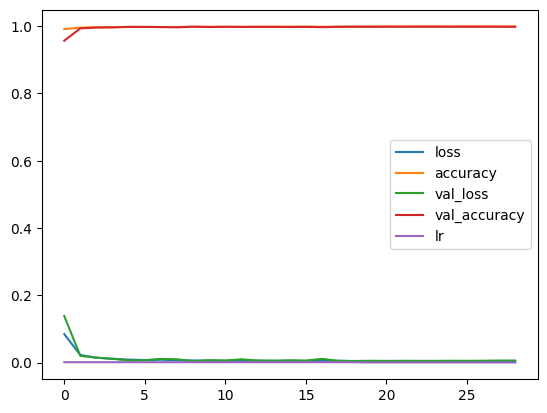

In [27]:
pd.DataFrame(history_Densenet.history).plot()

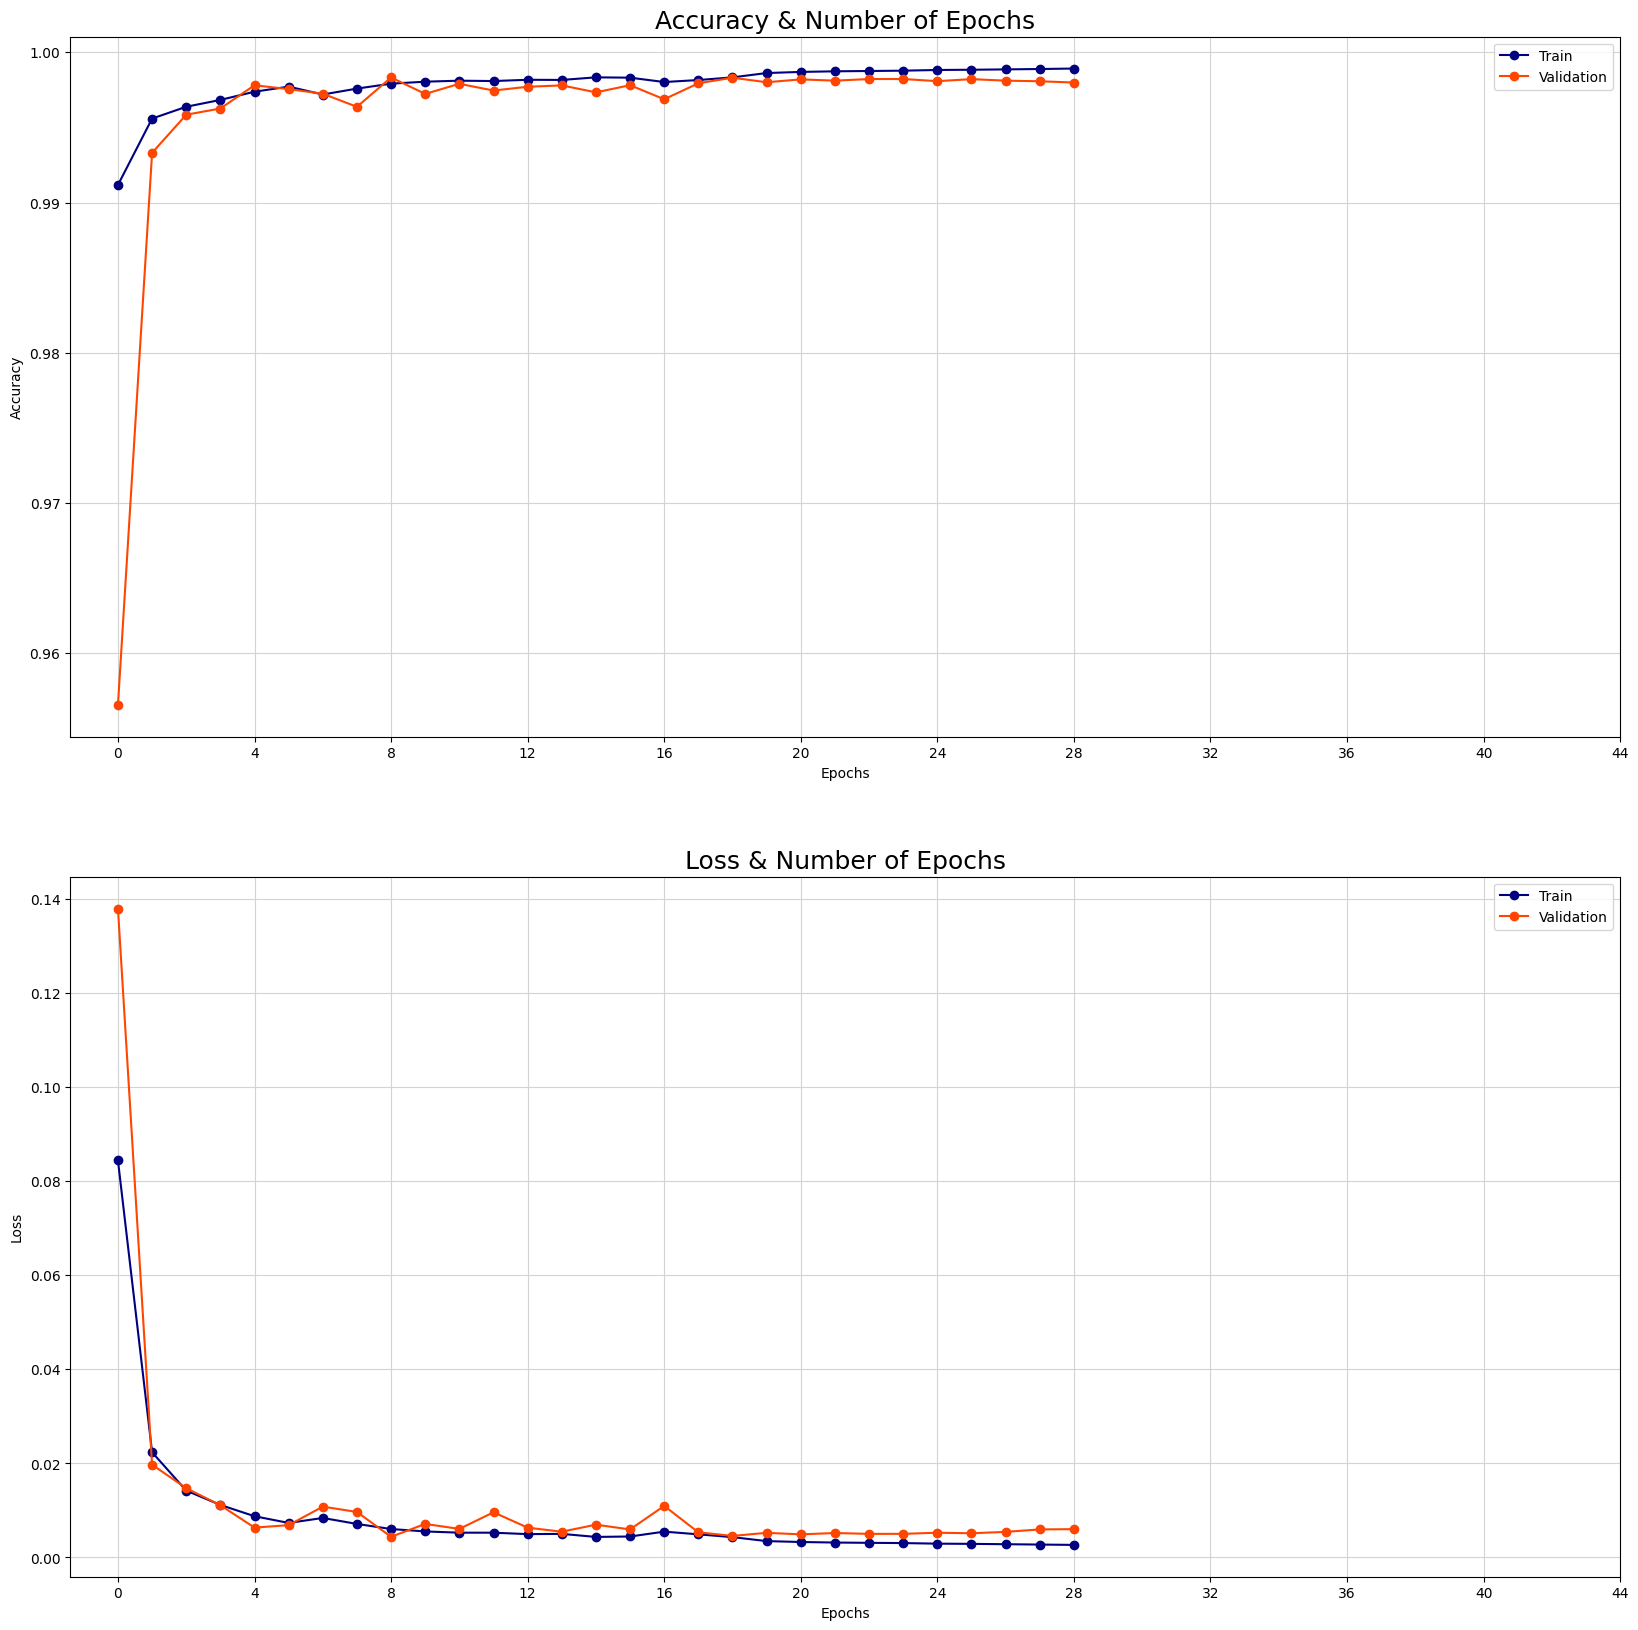

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax = ax.ravel()
metrics_unet = ['Accuracy', 'Loss']

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_Densenet.history[met], 'o-',color= 'navy')
    ax[i].plot(history_Densenet.history['val_' + met], 'o-',color= 'orangered')
    ax[i].set_title('{} & Number of Epochs'.format(metrics_unet[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics_unet[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")

In [29]:
y_pred_Densenet=model_Densenet.predict(test_gen, steps= test_steps)

131/131 [==============================] - 16s 112ms/step


In [30]:
model_Densenet.save("./Densenet_Unet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 32ms/step


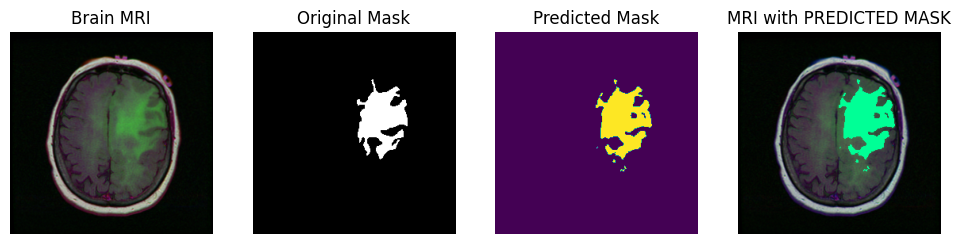

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


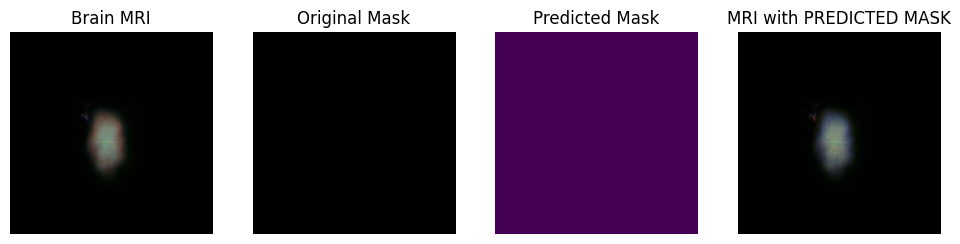

1/1 [==============================] - 0s 29ms/step


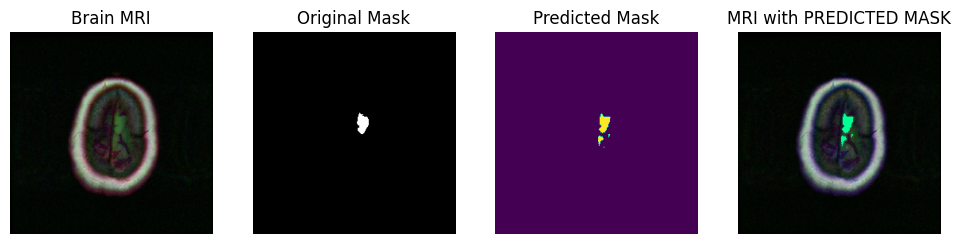

1/1 [==============================] - 0s 36ms/step


In [36]:
#visualizing prediction
for _ in range(6):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['image_path'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model_Densenet.predict(img)

    plt.figure(figsize=(12, 12))

    plt.subplot(1, 4, 1)
    plt.imshow(np.array(img).squeeze())
    plt.axis('off')
    plt.title('Brain MRI')

    plt.subplot(1, 4, 2)
    mask = cv2.imread(test_df['mask_path'].iloc[index])
    plt.imshow(np.array(mask).squeeze())
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 4, 3)
    pred = np.array(predicted_img).squeeze().round()
    plt.imshow(pred)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    img_ = cv2.imread(test_df['image_path'].iloc[index])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[pred==1] = (0,255,150)
    plt.imshow(img_)
    plt.title('MRI with PREDICTED MASK')
    plt.axis('off')

    plt.show()